# **1. LIBRARY**

In [22]:
import os
import pickle
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
from scipy.spatial.distance import directed_hausdorff
from keras.saving import load_model
from keras.losses import BinaryCrossentropy
from IPython.display import display, Markdown

import warnings
warnings.filterwarnings("ignore")

# **2. DATASET**

In [1]:
img_size = 128

In [5]:
cxr = np.load('/kaggle/input/lung-segmentation-dataset-ch0/without_convexhull/test/cxr.npy')
mask = np.load('/kaggle/input/lung-segmentation-dataset-ch0/without_convexhull/test/mask.npy')

print(np.shape(cxr))
print(np.shape(mask))

(2119, 128, 128)
(2119, 128, 128)


In [6]:
cxr = np.array(cxr / 255)
mask = np.array(mask / 255) >= 0.5

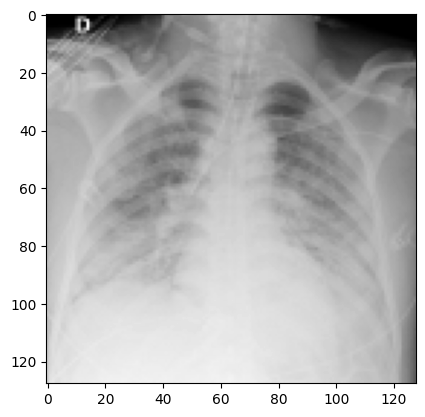

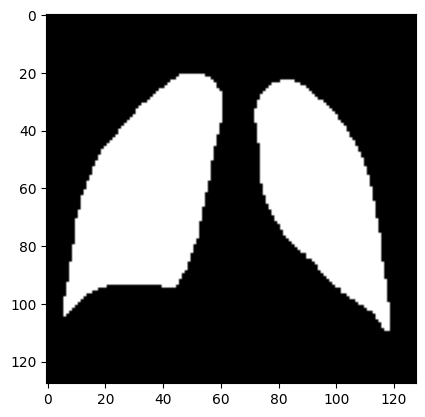

In [7]:
idx = 0
plt.imshow(cxr[idx], cmap='gray')
plt.show()
plt.imshow(mask[idx], cmap='gray')
plt.show()

# **3. METRIC**

In [39]:
def bce_loss(y_true, y_pred):
    epsilon = 1e-9
    bce = -np.mean(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))
    return bce

In [40]:
def mean_dice(y_true, y_pred):
    y_true = np.array(y_true, dtype=int)
    y_pred = np.array(y_pred >= 0.5, dtype=int)
    dice_list = []
    for i in range(np.shape(cxr)[0]):
        intersection = np.sum(y_true[i] & y_pred[i])
        combination = np.sum(y_true[i]) + np.sum(y_pred[i])
        dice = intersection * 2 / combination
        dice_list.append(dice)
    return np.mean(dice_list)

In [41]:
def mean_iou(y_true, y_pred):
    y_true = np.array(y_true, dtype=int)
    y_pred = np.array(y_pred >= 0.5, dtype=int)
    iou_list = []
    for i in range(np.shape(cxr)[0]):
        intersection = np.sum(y_true[i] & y_pred[i])
        union = np.sum(y_true[i] | y_pred[i])
        iou = intersection / union
        iou_list.append(iou)
    return np.mean(iou_list)

In [42]:
def mean_accuracy(y_true, y_pred):
    y_true = np.array(y_true.reshape(np.shape(cxr)[0], -1), dtype=int)
    y_pred = np.array(y_pred.reshape(np.shape(cxr)[0], -1) >= 0.5, dtype=int)
    accuracy_list = []
    for i in range(np.shape(cxr)[0]):
        accuracy = accuracy_score(y_true[i], y_pred[i])
        accuracy_list.append(accuracy)
    return np.mean(accuracy_list)

In [43]:
def mean_precision(y_true, y_pred):
    y_true = np.array(y_true.reshape(np.shape(cxr)[0], -1), dtype=int)
    y_pred = np.array(y_pred.reshape(np.shape(cxr)[0], -1) >= 0.5, dtype=int)
    precision_list = []
    for i in range(np.shape(cxr)[0]):
        precision = precision_score(y_true[i], y_pred[i])
        precision_list.append(precision)
    return np.mean(precision_list)

In [44]:
def mean_recall(y_true, y_pred):
    y_true = np.array(y_true.reshape(np.shape(cxr)[0], -1), dtype=int)
    y_pred = np.array(y_pred.reshape(np.shape(cxr)[0], -1) >= 0.5, dtype=int)
    recall_list = []
    for i in range(np.shape(cxr)[0]):
        recall = recall_score(y_true[i], y_pred[i])
        recall_list.append(recall)
    return np.mean(recall_list)

In [45]:
def mean_f1score(y_true, y_pred):
    y_true = np.array(y_true.reshape(np.shape(cxr)[0], -1), dtype=int)
    y_pred = np.array(y_pred.reshape(np.shape(cxr)[0], -1) >= 0.5, dtype=int)
    f1score_list = []
    for i in range(np.shape(cxr)[0]):
        f1score = f1_score(y_true[i], y_pred[i])
        f1score_list.append(f1score)
    return np.mean(f1score_list)

In [46]:
def mean_specificity(y_true, y_pred):
    y_true = np.array(y_true.reshape(np.shape(cxr)[0], -1), dtype=int)
    y_pred = np.array(y_pred.reshape(np.shape(cxr)[0], -1) >= 0.5, dtype=int)
    specificity_list = []
    for i in range(np.shape(cxr)[0]):
        TN = np.sum((y_true[i] == 0) & (y_pred[i] == 0))
        FP = np.sum((y_true[i] == 0) & (y_pred[i] == 1))
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificity_list.append(specificity)
    return np.mean(specificity_list)

# **4. MODEL**

In [23]:
unet = load_model('/kaggle/input/unet/keras/default/20/without_convexhull/model/U-Net.h5')

unet.summary()

with open('/kaggle/input/unet/keras/default/20/without_convexhull/history/train_loss.pkl', 'rb') as f:
    history_train_loss_unet = pickle.load(f)
with open('/kaggle/input/unet/keras/default/20/without_convexhull/history/train_dice.pkl', 'rb') as f:
    history_train_dice_unet = pickle.load(f)
with open('/kaggle/input/unet/keras/default/20/without_convexhull/history/train_iou.pkl', 'rb') as f:
    history_train_iou_unet = pickle.load(f)
with open('/kaggle/input/unet/keras/default/20/without_convexhull/history/val_loss.pkl', 'rb') as f:
    history_val_loss_unet = pickle.load(f)
with open('/kaggle/input/unet/keras/default/20/without_convexhull/history/val_dice.pkl', 'rb') as f:
    history_val_dice_unet = pickle.load(f)
with open('/kaggle/input/unet/keras/default/20/without_convexhull/history/val_iou.pkl', 'rb') as f:
    history_val_iou_unet = pickle.load(f)

Model: "unet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet_down0_0 (Conv2D)     │ (None, 128, 128, 16)   │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet_down0_0_activation   │ (None, 128, 128, 16)   │              0 │ unet_down0_0[0][0]     │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet_down0_1 (Conv2D)     │ (None, 128, 128, 16)   │          2,320 │ unet_down0_0_activati… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet_down0_1_activation   │ (None, 128, 128, 16)   │              0 │ unet_down0_1[0][0]     │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet_down1_encode_maxpool │ (None, 64, 64, 16)     │              0 │ unet_down0_1_activati… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet_down1_conv_0         │ (None, 64, 64, 32)     │          4,640 │ unet_down1_encode_max… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet_down1_conv_0_activa… │ (None, 64, 64, 32)     │              0 │ unet_down1_conv_0[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet_down1_conv_1         │ (None, 64, 64, 32)     │          9,248 │ unet_down1_conv_0_act… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet_down1_conv_1_activa… │ (None, 64, 64, 32)     │              0 │ unet_down1_conv_1[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet_down2_encode_maxpool │ (None, 32, 32, 32)     │              0 │ unet_down1_conv_1_act… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet_down2_conv_0         │ (None, 32, 32, 64)     │         18,496 │ unet_down2_encode_max… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet_down2_conv_0_activa… │ (None, 32, 32, 64)     │              0 │ unet_down2_conv_0[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet_down2_conv_1         │ (None, 32, 32, 64)     │         36,928 │ unet_down2_conv_0_act… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 2,158,419 (8.23 MB)

 Trainable params: 2,158,417 (8.23 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [24]:
attunet = load_model('/kaggle/input/unet/keras/default/21/without_convexhull/model/Attention_U-Net.h5')

attunet.summary()

with open('/kaggle/input/unet/keras/default/21/without_convexhull/history/train_loss.pkl', 'rb') as f:
    history_train_loss_attunet = pickle.load(f)
with open('/kaggle/input/unet/keras/default/21/without_convexhull/history/train_dice.pkl', 'rb') as f:
    history_train_dice_attunet = pickle.load(f)
with open('/kaggle/input/unet/keras/default/21/without_convexhull/history/train_iou.pkl', 'rb') as f:
    history_train_iou_attunet = pickle.load(f)
with open('/kaggle/input/unet/keras/default/21/without_convexhull/history/val_loss.pkl', 'rb') as f:
    history_val_loss_attunet = pickle.load(f)
with open('/kaggle/input/unet/keras/default/21/without_convexhull/history/val_dice.pkl', 'rb') as f:
    history_val_dice_attunet = pickle.load(f)
with open('/kaggle/input/unet/keras/default/21/without_convexhull/history/val_iou.pkl', 'rb') as f:
    history_val_iou_attunet = pickle.load(f)

Model: "attunet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attunet_down0_0 (Conv2D)  │ (None, 128, 128, 16)   │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attunet_down0_0_activati… │ (None, 128, 128, 16)   │              0 │ attunet_down0_0[0][0]  │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attunet_down0_1 (Conv2D)  │ (None, 128, 128, 16)   │          2,320 │ attunet_down0_0_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attunet_down0_1_activati… │ (None, 128, 128, 16)   │              0 │ attunet_down0_1[0][0]  │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attunet_down1_encode_max… │ (None, 64, 64, 16)     │              0 │ attunet_down0_1_activ… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attunet_down1_conv_0      │ (None, 64, 64, 32)     │          4,640 │ attunet_down1_encode_… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attunet_down1_conv_0_act… │ (None, 64, 64, 32)     │              0 │ attunet_down1_conv_0[… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attunet_down1_conv_1      │ (None, 64, 64, 32)     │          9,248 │ attunet_down1_conv_0_… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attunet_down1_conv_1_act… │ (None, 64, 64, 32)     │              0 │ attunet_down1_conv_1[… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attunet_down2_encode_max… │ (None, 32, 32, 32)     │              0 │ attunet_down1_conv_1_… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attunet_down2_conv_0      │ (None, 32, 32, 64)     │         18,496 │ attunet_down2_encode_… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attunet_down2_conv_0_act… │ (None, 32, 32, 64)     │              0 │ attunet_down2_conv_0[… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attunet_down2_conv_1      │ (None, 32, 32, 64)     │         36,928 │ attunet_down2_conv_0_… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 1,995,343 (7.61 MB)

 Trainable params: 1,995,341 (7.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [26]:
unetpp = load_model('/kaggle/input/unet/keras/default/24/without_convexhull/model/U-Net++.h5')

unetpp.summary()

with open('/kaggle/input/unet/keras/default/24/without_convexhull/history/train_loss.pkl', 'rb') as f:
    history_train_loss_unetpp = pickle.load(f)
with open('/kaggle/input/unet/keras/default/24/without_convexhull/history/train_dice.pkl', 'rb') as f:
    history_train_dice_unetpp = pickle.load(f)
with open('/kaggle/input/unet/keras/default/24/without_convexhull/history/train_iou.pkl', 'rb') as f:
    history_train_iou_unetpp = pickle.load(f)
with open('/kaggle/input/unet/keras/default/24/without_convexhull/history/val_loss.pkl', 'rb') as f:
    history_val_loss_unetpp = pickle.load(f)
with open('/kaggle/input/unet/keras/default/24/without_convexhull/history/val_dice.pkl', 'rb') as f:
    history_val_dice_unetpp = pickle.load(f)
with open('/kaggle/input/unet/keras/default/24/without_convexhull/history/val_iou.pkl', 'rb') as f:
    history_val_iou_unetpp = pickle.load(f)

Model: "xnet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xnet_down0_0 (Conv2D)                │ (None, 128, 128, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xnet_down0_0_activation (ReLU)       │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xnet_down0_1 (Conv2D)                │ (None, 128, 128, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xnet_down0_1_activation (ReLU)       │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xnet_down1_encode_maxpool            │ (None, 64, 64, 16)          │               0 │
│ (MaxPooling2D)                       │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xnet_down1_conv_0 (Conv2D)           │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xnet_down1_conv_0_activation (ReLU)  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xnet_down1_conv_1 (Conv2D)           │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xnet_down1_conv_1_activation (ReLU)  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xnet_down2_encode_maxpool            │ (None, 32, 32, 32)          │               0 │
│ (MaxPooling2D)                       │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xnet_down2_conv_0 (Conv2D)           │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xnet_down2_conv_0_activation (ReLU)  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xnet_down2_conv_1 (Conv2D)           │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xnet_down2_conv_1_activation (ReLU)  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xnet_down3_encode_maxpool            │ (None, 16, 16, 64)          │               0 │
│ (MaxPooling2D)                       │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xnet_down3_conv_0 (Conv2D)           │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xnet_down3_conv_0_activation (ReLU)  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xnet_down3_conv_1 (Conv2D)           │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xnet_down3_conv_1_activation (ReLU)  │ (None, 16, 16, 128)         │              

 Total params: 1,962,579 (7.49 MB)

 Trainable params: 1,962,577 (7.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [27]:
r2unet = load_model('/kaggle/input/unet/keras/default/23/without_convexhull/model/R2U-Net.h5')

r2unet.summary()

with open('/kaggle/input/unet/keras/default/23/without_convexhull/history/train_loss.pkl', 'rb') as f:
    history_train_loss_r2unet = pickle.load(f)
with open('/kaggle/input/unet/keras/default/23/without_convexhull/history/train_dice.pkl', 'rb') as f:
    history_train_dice_r2unet = pickle.load(f)
with open('/kaggle/input/unet/keras/default/23/without_convexhull/history/train_iou.pkl', 'rb') as f:
    history_train_iou_r2unet = pickle.load(f)
with open('/kaggle/input/unet/keras/default/23/without_convexhull/history/val_loss.pkl', 'rb') as f:
    history_val_loss_r2unet = pickle.load(f)
with open('/kaggle/input/unet/keras/default/23/without_convexhull/history/val_dice.pkl', 'rb') as f:
    history_val_dice_r2unet = pickle.load(f)
with open('/kaggle/input/unet/keras/default/23/without_convexhull/history/val_iou.pkl', 'rb') as f:
    history_val_iou_r2unet = pickle.load(f)

Model: "r2_unet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ r2_unet_input             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_conv        │ (None, 128, 128, 16)   │             32 │ r2_unet_input[0][0]    │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_conv0       │ (None, 128, 128, 16)   │          2,320 │ r2_unet_down0_conv[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_activation0 │ (None, 128, 128, 16)   │              0 │ r2_unet_down0_conv0[0… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_add0_0      │ (None, 128, 128, 16)   │              0 │ r2_unet_down0_activat… │
│ (Add)                     │                        │                │ r2_unet_down0_conv[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_conv0_0     │ (None, 128, 128, 16)   │          2,320 │ r2_unet_down0_add0_0[… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_activation… │ (None, 128, 128, 16)   │              0 │ r2_unet_down0_conv0_0… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_add0_1      │ (None, 128, 128, 16)   │              0 │ r2_unet_down0_activat… │
│ (Add)                     │                        │                │ r2_unet_down0_conv[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_conv0_1     │ (None, 128, 128, 16)   │          2,320 │ r2_unet_down0_add0_1[… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_activation… │ (None, 128, 128, 16)   │              0 │ r2_unet_down0_conv0_1… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_conv1       │ (None, 128, 128, 16)   │          2,320 │ r2_unet_down0_activat… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_activation1 │ (None, 128, 128, 16)   │              0 │ r2_unet_down0_conv1[0… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_add1_0      │ (None, 128, 128, 16)   │              0 │ r2_unet_down0_activat… │
│ (Add)                     │                        │                │ r2_unet_down0_activat… │
├──────────────────────

 Total params: 6,373,171 (24.31 MB)

 Trainable params: 6,373,169 (24.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

# **5. RESULT**

## **5.1. Training Curve**

### **5.1.1. Train Loss**

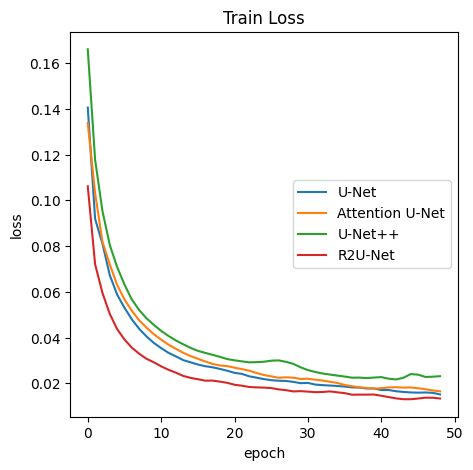

In [29]:
plt.figure(figsize=(5, 5))
plt.plot(history_train_loss_unet[1:])
plt.plot(history_train_loss_attunet[1:])
plt.plot(history_train_loss_unetpp[1:])
plt.plot(history_train_loss_r2unet[1:])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Train Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['U-Net', 'Attention U-Net', 'U-Net++', 'R2U-Net'], loc='center right')
plt.show()
plt.close()

### **5.1.2. Train Dice**

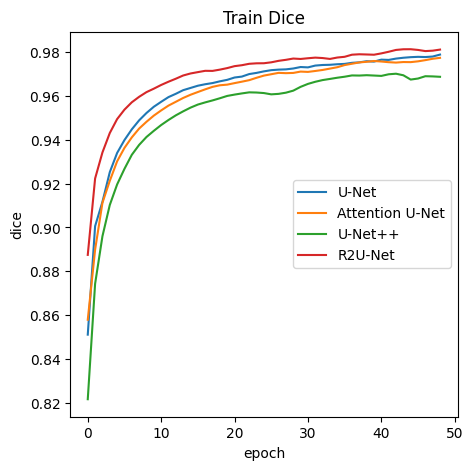

In [30]:
plt.figure(figsize=(5, 5))
plt.plot(history_train_dice_unet[1:])
plt.plot(history_train_dice_attunet[1:])
plt.plot(history_train_dice_unetpp[1:])
plt.plot(history_train_dice_r2unet[1:])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Train Dice')
plt.ylabel('dice')
plt.xlabel('epoch')
plt.legend(['U-Net', 'Attention U-Net', 'U-Net++', 'R2U-Net'], loc='center right')
plt.show()
plt.close()

### **5.1.3. Train IoU**

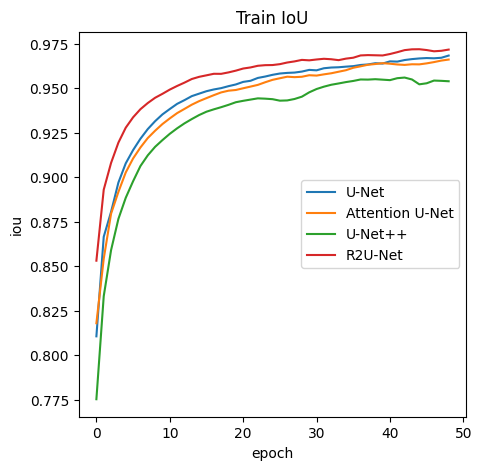

In [31]:
plt.figure(figsize=(5, 5))
plt.plot(history_train_iou_unet[1:])
plt.plot(history_train_iou_attunet[1:])
plt.plot(history_train_iou_unetpp[1:])
plt.plot(history_train_iou_r2unet[1:])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Train IoU')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['U-Net', 'Attention U-Net', 'U-Net++', 'R2U-Net'], loc='center right')
plt.show()
plt.close()

### **5.1.4. Train Loss**

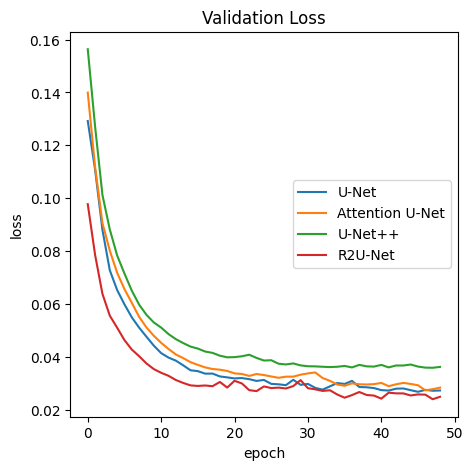

In [32]:
plt.figure(figsize=(5, 5))
plt.plot(history_val_loss_unet[1:])
plt.plot(history_val_loss_attunet[1:])
plt.plot(history_val_loss_unetpp[1:])
plt.plot(history_val_loss_r2unet[1:])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['U-Net', 'Attention U-Net', 'U-Net++', 'R2U-Net'], loc='center right')
plt.show()
plt.close()

### **5.1.5. Validation Dice**

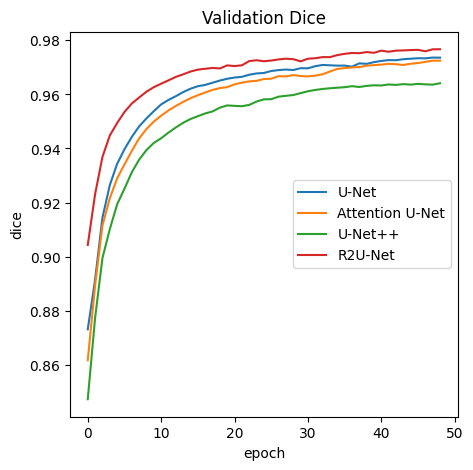

In [33]:
plt.figure(figsize=(5, 5))
plt.plot(history_val_dice_unet[1:])
plt.plot(history_val_dice_attunet[1:])
plt.plot(history_val_dice_unetpp[1:])
plt.plot(history_val_dice_r2unet[1:])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Validation Dice')
plt.ylabel('dice')
plt.xlabel('epoch')
plt.legend(['U-Net', 'Attention U-Net', 'U-Net++', 'R2U-Net'], loc='center right')
plt.show()
plt.close()

### **5.1.6. Validation IoU**

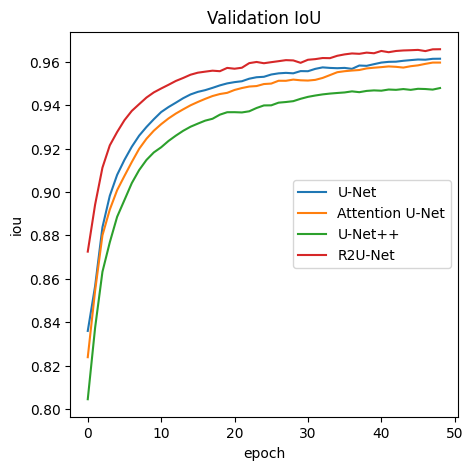

In [34]:
plt.figure(figsize=(5, 5))
plt.plot(history_val_iou_unet[1:])
plt.plot(history_val_iou_attunet[1:])
plt.plot(history_val_iou_unetpp[1:])
plt.plot(history_val_iou_r2unet[1:])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Validation IoU')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['U-Net', 'Attention U-Net', 'U-Net++', 'R2U-Net'], loc='center right')
plt.show()
plt.close()

## **5.2. Performance on Testset**

### **5.2.1. Test Results Summary**

In [35]:
mask_unet = unet.predict(cxr.reshape(-1, img_size, img_size, 1), verbose=True).reshape(-1, img_size, img_size)
mask_attunet = attunet.predict(cxr.reshape(-1, img_size, img_size, 1), verbose=True).reshape(-1, img_size, img_size)
mask_unetpp = unetpp.predict(cxr.reshape(-1, img_size, img_size, 1), verbose=True).reshape(-1, img_size, img_size)
mask_r2unet = r2unet.predict(cxr.reshape(-1, img_size, img_size, 1), verbose=True).reshape(-1, img_size, img_size)

print(np.shape(mask_unet))
print(np.shape(mask_attunet))
print(np.shape(mask_unetpp))
print(np.shape(mask_r2unet))

67/67 ━━━━━━━━━━━━━━━━━━━━ 58s 861ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 54s 806ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 48s 714ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step
(2119, 128, 128)
(2119, 128, 128)
(2119, 128, 128)
(2119, 128, 128)


In [48]:
print('Calculating metrics for U-Net...', end=' ')
loss_unet = bce_loss(mask, mask_unet)
dice_unet = mean_dice(mask, mask_unet)
iou_unet = mean_iou(mask, mask_unet)
accuracy_unet = mean_accuracy(mask, mask_unet)
precision_unet = mean_precision(mask, mask_unet)
recall_unet = mean_recall(mask, mask_unet)
f1score_unet = mean_f1score(mask, mask_unet)
specificity_unet = mean_specificity(mask, mask_unet)
print('Done !')

print('Calculating metrics for Attention U-Net...', end=' ')
loss_attunet = bce_loss(mask, mask_attunet)
dice_attunet = mean_dice(mask, mask_attunet)
iou_attunet = mean_iou(mask, mask_attunet)
accuracy_attunet = mean_accuracy(mask, mask_attunet)
precision_attunet = mean_precision(mask, mask_attunet)
recall_attunet = mean_recall(mask, mask_attunet)
f1score_attunet = mean_f1score(mask, mask_attunet)
specificity_attunet = mean_specificity(mask, mask_attunet)
print('Done !')

print('Calculating metrics for U-Net++...', end=' ')
loss_unetpp = bce_loss(mask, mask_unetpp)
dice_unetpp = mean_dice(mask, mask_unetpp)
iou_unetpp = mean_iou(mask, mask_unetpp)
accuracy_unetpp = mean_accuracy(mask, mask_unetpp)
precision_unetpp = mean_precision(mask, mask_unetpp)
recall_unetpp = mean_recall(mask, mask_unetpp)
f1score_unetpp = mean_f1score(mask, mask_unetpp)
specificity_unetpp = mean_specificity(mask, mask_unetpp)
print('Done !')

print('Calculating metrics for R2U-Net...', end=' ')
loss_r2unet = bce_loss(mask, mask_r2unet)
dice_r2unet = mean_dice(mask, mask_r2unet)
iou_r2unet = mean_iou(mask, mask_r2unet)
accuracy_r2unet = mean_accuracy(mask, mask_r2unet)
precision_r2unet = mean_precision(mask, mask_r2unet)
recall_r2unet = mean_recall(mask, mask_r2unet)
f1score_r2unet = mean_f1score(mask, mask_r2unet)
specificity_r2unet = mean_specificity(mask, mask_r2unet)
print('Done !')

Calculating metrics for U-Net... Done !
Calculating metrics for Attention U-Net... Done !
Calculating metrics for U-Net++... Done !
Calculating metrics for R2U-Net... Done !


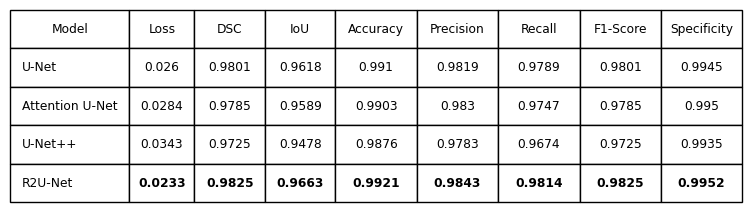

In [50]:
models = ['U-Net', 'Attention U-Net', 'U-Net++', 'R2U-Net']

loss = []
loss.append(str(round(loss_unet, 4)))
loss.append(str(round(loss_attunet, 4)))
loss.append(str(round(loss_unetpp, 4)))
loss.append(str(round(loss_r2unet, 4)))

dice = []
dice.append(str(round(dice_unet, 4)))
dice.append(str(round(dice_attunet, 4)))
dice.append(str(round(dice_unetpp, 4)))
dice.append(str(round(dice_r2unet, 4)))

iou = []
iou.append(str(round(iou_unet, 4)))
iou.append(str(round(iou_attunet, 4)))
iou.append(str(round(iou_unetpp, 4)))
iou.append(str(round(iou_r2unet, 4)))

accuracy = []
accuracy.append(str(round(accuracy_unet, 4)))
accuracy.append(str(round(accuracy_attunet, 4)))
accuracy.append(str(round(accuracy_unetpp, 4)))
accuracy.append(str(round(accuracy_r2unet, 4)))

precision = []
precision.append(str(round(precision_unet, 4)))
precision.append(str(round(precision_attunet, 4)))
precision.append(str(round(precision_unetpp, 4)))
precision.append(str(round(precision_r2unet, 4)))

recall = []
recall.append(str(round(recall_unet, 4)))
recall.append(str(round(recall_attunet, 4)))
recall.append(str(round(recall_unetpp, 4)))
recall.append(str(round(recall_r2unet, 4)))

f1score = []
f1score.append(str(round(f1score_unet, 4)))
f1score.append(str(round(f1score_attunet, 4)))
f1score.append(str(round(f1score_unetpp, 4)))
f1score.append(str(round(f1score_r2unet, 4)))

specificity = []
specificity.append(str(round(specificity_unet, 4)))
specificity.append(str(round(specificity_attunet, 4)))
specificity.append(str(round(specificity_unetpp, 4)))
specificity.append(str(round(specificity_r2unet, 4)))

df = pd.DataFrame({'Model': models, 'Loss': loss, 'DSC': dice, 'IoU': iou, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1score, 'Specificity': specificity})

fig, ax = plt.subplots(figsize=(7, 1))
ax.axis("tight")
ax.axis("off")

table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc="center", loc="center", colWidths=[0.15, 0.1, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15])

col_widths = [0.22, 0.12, 0.13, 0.13, 0.15, 0.15, 0.15, 0.15, 0.15]
for i, width in enumerate(col_widths):
    for j in range(5):
        table[(j, i)].set_width(width)
        table[(j, i)].set_height(0.5)

for (i, j), cell in table._cells.items():
    if i == 0: 
        cell.set_text_props(ha="center")
    elif j == 0:
        cell.set_text_props(ha="left")
    elif j == 1:
        cell.set_text_props(ha="center")
        if i == 4:
            cell.set_text_props(weight="bold", color="black")
    elif j == 2:
        cell.set_text_props(ha="center")
        if i == 4:
            cell.set_text_props(weight="bold", color="black")
    elif j == 3:
        cell.set_text_props(ha="center")
        if i == 4:
            cell.set_text_props(weight="bold", color="black")
    elif j == 4:
        cell.set_text_props(ha="center")
        if i == 4:
            cell.set_text_props(weight="bold", color="black")
    elif j == 5:
        cell.set_text_props(ha="center")
        if i == 4:
            cell.set_text_props(weight="bold", color="black")
    elif j == 6:
        cell.set_text_props(ha="center")
        if i == 4:
            cell.set_text_props(weight="bold", color="black")
    elif j == 7:
        cell.set_text_props(ha="center")
        if i == 4:
            cell.set_text_props(weight="bold", color="black")
    elif j == 8:
        cell.set_text_props(ha="center")
        if i == 4:
            cell.set_text_props(weight="bold", color="black")

table.auto_set_font_size(False)
table.set_fontsize(8.8)
            
plt.show()

### **5.2.2. Visualization**

In [54]:
def save_image(path, image, name):
    image = (image * 255).astype(np.uint8)
    save_path = os.path.join(path, name + '.png')
    cv2.imwrite(save_path, image)

In [55]:
def read_image(path, name):
    read_path = os.path.join(path, name + '.png')
    image = cv2.imread(read_path)
    return image

In [81]:
idx = [0, 400, 970, 1500]

!rm -rf /kaggle/working/*
save_image('/kaggle/working/', cxr[idx[0]], str(idx[0]))
save_image('/kaggle/working/', cxr[idx[1]], str(idx[1]))
save_image('/kaggle/working/', cxr[idx[2]], str(idx[2]))
save_image('/kaggle/working/', cxr[idx[3]], str(idx[3]))
cxr_1 = read_image('/kaggle/working/', str(idx[0]))
cxr_2 = read_image('/kaggle/working/', str(idx[1]))
cxr_3 = read_image('/kaggle/working/', str(idx[2]))
cxr_4 = read_image('/kaggle/working/', str(idx[3]))

!rm -rf /kaggle/working/*
save_image('/kaggle/working/', mask[idx[0]], str(idx[0]))
save_image('/kaggle/working/', mask[idx[1]], str(idx[1]))
save_image('/kaggle/working/', mask[idx[2]], str(idx[2]))
save_image('/kaggle/working/', mask[idx[3]], str(idx[3]))
mask_1 = read_image('/kaggle/working/', str(idx[0]))
mask_2 = read_image('/kaggle/working/', str(idx[1]))
mask_3 = read_image('/kaggle/working/', str(idx[2]))
mask_4 = read_image('/kaggle/working/', str(idx[3]))

!rm -rf /kaggle/working/*
save_image('/kaggle/working/', mask_unet[idx[0]] >= 0.5, str(idx[0]))
save_image('/kaggle/working/', mask_unet[idx[1]] >= 0.5, str(idx[1]))
save_image('/kaggle/working/', mask_unet[idx[2]] >= 0.5, str(idx[2]))
save_image('/kaggle/working/', mask_unet[idx[3]] >= 0.5, str(idx[3]))
mask_unet_1 = read_image('/kaggle/working/', str(idx[0]))
mask_unet_2 = read_image('/kaggle/working/', str(idx[1]))
mask_unet_3 = read_image('/kaggle/working/', str(idx[2]))
mask_unet_4 = read_image('/kaggle/working/', str(idx[3]))

!rm -rf /kaggle/working/*
save_image('/kaggle/working/', mask_attunet[idx[0]] >= 0.5, str(idx[0]))
save_image('/kaggle/working/', mask_attunet[idx[1]] >= 0.5, str(idx[1]))
save_image('/kaggle/working/', mask_attunet[idx[2]] >= 0.5, str(idx[2]))
save_image('/kaggle/working/', mask_attunet[idx[3]] >= 0.5, str(idx[3]))
mask_attunet_1 = read_image('/kaggle/working/', str(idx[0]))
mask_attunet_2 = read_image('/kaggle/working/', str(idx[1]))
mask_attunet_3 = read_image('/kaggle/working/', str(idx[2]))
mask_attunet_4 = read_image('/kaggle/working/', str(idx[3]))

!rm -rf /kaggle/working/*
save_image('/kaggle/working/', mask_unetpp[idx[0]] >= 0.5, str(idx[0]))
save_image('/kaggle/working/', mask_unetpp[idx[1]] >= 0.5, str(idx[1]))
save_image('/kaggle/working/', mask_unetpp[idx[2]] >= 0.5, str(idx[2]))
save_image('/kaggle/working/', mask_unetpp[idx[3]] >= 0.5, str(idx[3]))
mask_unetpp_1 = read_image('/kaggle/working/', str(idx[0]))
mask_unetpp_2 = read_image('/kaggle/working/', str(idx[1]))
mask_unetpp_3 = read_image('/kaggle/working/', str(idx[2]))
mask_unetpp_4 = read_image('/kaggle/working/', str(idx[3]))

!rm -rf /kaggle/working/*
save_image('/kaggle/working/', mask_r2unet[idx[0]] >= 0.5, str(idx[0]))
save_image('/kaggle/working/', mask_r2unet[idx[1]] >= 0.5, str(idx[1]))
save_image('/kaggle/working/', mask_r2unet[idx[2]] >= 0.5, str(idx[2]))
save_image('/kaggle/working/', mask_r2unet[idx[3]] >= 0.5, str(idx[3]))
mask_r2unet_1 = read_image('/kaggle/working/', str(idx[0]))
mask_r2unet_2 = read_image('/kaggle/working/', str(idx[1]))
mask_r2unet_3 = read_image('/kaggle/working/', str(idx[2]))
mask_r2unet_4 = read_image('/kaggle/working/', str(idx[3]))

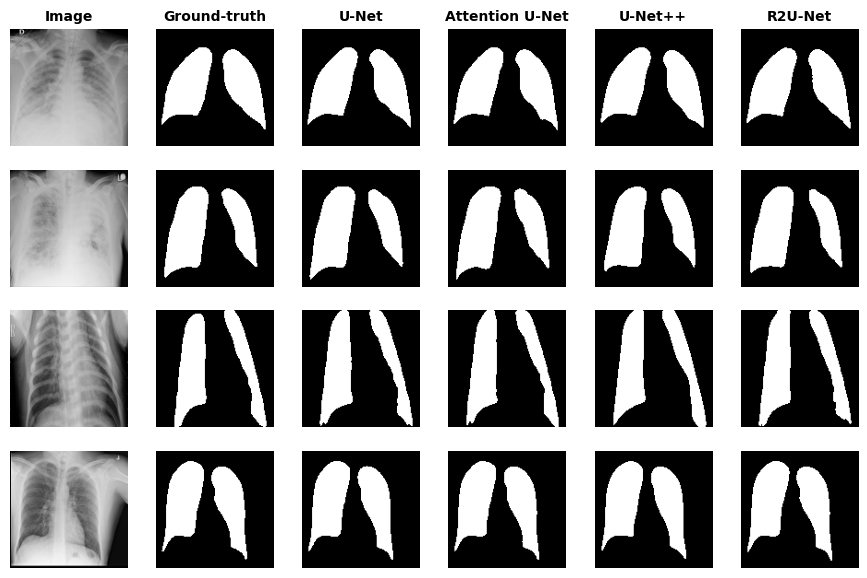

In [83]:
fig, axs = plt.subplots(4, 6, figsize=(11, 7))

for ax in axs.flat:
    ax.axis('off')

axs[0, 0].set_title('Image', fontsize=10, fontweight='bold')
axs[0, 0].imshow(cxr_1, cmap='gray')
axs[1, 0].imshow(cxr_2, cmap='gray')
axs[2, 0].imshow(cxr_3, cmap='gray')
axs[3, 0].imshow(cxr_4, cmap='gray')

axs[0, 1].set_title('Ground-truth', fontsize=10, fontweight='bold')
axs[0, 1].imshow(mask_1, cmap='gray')
axs[1, 1].imshow(mask_2, cmap='gray')
axs[2, 1].imshow(mask_3, cmap='gray')
axs[3, 1].imshow(mask_4, cmap='gray')

axs[0, 2].set_title('U-Net', fontsize=10, fontweight='bold')
axs[0, 2].imshow(mask_unet_1, cmap='gray')
axs[1, 2].imshow(mask_unet_2, cmap='gray')
axs[2, 2].imshow(mask_unet_3, cmap='gray')
axs[3, 2].imshow(mask_unet_4, cmap='gray')

axs[0, 3].set_title('Attention U-Net', fontsize=10, fontweight='bold')
axs[0, 3].imshow(mask_attunet_1, cmap='gray')
axs[1, 3].imshow(mask_attunet_2, cmap='gray')
axs[2, 3].imshow(mask_attunet_3, cmap='gray')
axs[3, 3].imshow(mask_attunet_4, cmap='gray')

axs[0, 4].set_title('U-Net++', fontsize=10, fontweight='bold')
axs[0, 4].imshow(mask_unetpp_1, cmap='gray')
axs[1, 4].imshow(mask_unetpp_2, cmap='gray')
axs[2, 4].imshow(mask_unetpp_3, cmap='gray')
axs[3, 4].imshow(mask_unetpp_4, cmap='gray')

axs[0, 5].set_title('R2U-Net', fontsize=10, fontweight='bold')
axs[0, 5].imshow(mask_r2unet_1, cmap='gray')
axs[1, 5].imshow(mask_r2unet_2, cmap='gray')
axs[2, 5].imshow(mask_r2unet_3, cmap='gray')
axs[3, 5].imshow(mask_r2unet_4, cmap='gray')